In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [2]:
notebook_dir = os.path.dirname(os.path.abspath("__file__"))  # Simulates the notebook's directory
print(notebook_dir)

file_path = os.path.join(notebook_dir, "./data/full_dataset.csv")
data = pd.read_csv(file_path)

/workspace/Betpredictornotebook/jupyter_notebooks


In [3]:
data.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,IWA,VCH,VCD,VCA,IWCH,IWCD,IWCA,VCCH,VCCD,VCCA
0,E0,16/08/2024,20:00,Man United,Fulham,1,0,H,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,17/08/2024,12:30,Ipswich,Liverpool,0,2,A,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,17/08/2024,15:00,Arsenal,Wolves,2,0,H,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,17/08/2024,15:00,Everton,Brighton,0,3,A,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,17/08/2024,15:00,Newcastle,Southampton,1,0,H,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Define a function for performing EDA
def perform_eda(data):
    print("Dataset Head:\n", data.head())
    print("Dataset Info:\n")
    data.info()
    print("Summary Statistics:\n", data.describe())

    # Plot histograms for numeric columns
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    data[numeric_columns].hist(figsize=(15, 10), bins=20, color='skyblue', edgecolor='black')
    plt.suptitle('Histograms of Numeric Features', fontsize=16)
    plt.tight_layout()
    plt.show()


Dataset Head:
   Div        Date   Time    HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
0  E0  16/08/2024  20:00  Man United       Fulham     1     0   H     0     0   
1  E0  17/08/2024  12:30     Ipswich    Liverpool     0     2   A     0     0   
2  E0  17/08/2024  15:00     Arsenal       Wolves     2     0   H     1     0   
3  E0  17/08/2024  15:00     Everton     Brighton     0     3   A     0     1   
4  E0  17/08/2024  15:00   Newcastle  Southampton     1     0   H     1     0   

   ... IWA VCH  VCD  VCA  IWCH  IWCD  IWCA  VCCH  VCCD  VCCA  
0  ... NaN NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1  ... NaN NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2  ... NaN NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3  ... NaN NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4  ... NaN NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 132 columns]
Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2099 entries, 0 to 2098
Columns

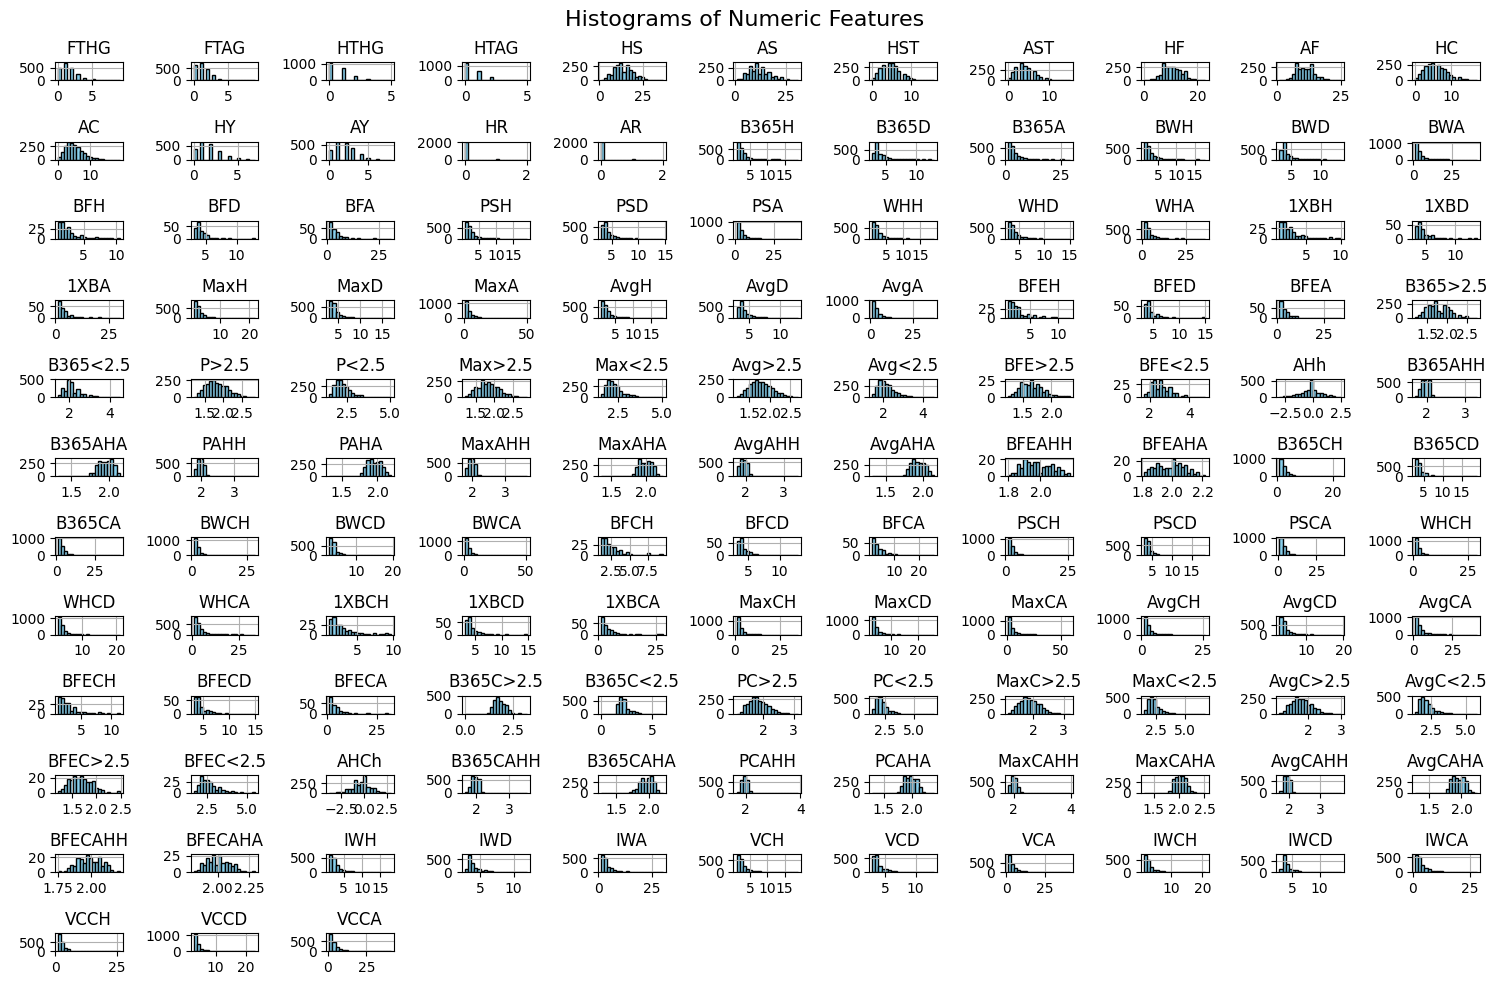

In [5]:
perform_eda(data)

In [9]:
# Feature selection
features = [
    'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST',
    'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 
    'AvgH', 'AvgD', 'AvgA'
]

# Feature engineering
data['GoalDifference'] = data['FTHG'] - data['FTAG']
data['MarketConsensus'] = (data['AvgH'] + data['AvgD'] + data['AvgA']) / 3
features.extend(['GoalDifference', 'MarketConsensus'])

In [10]:
def feature_engineering(data):
    # Map team names to numeric IDs
    team_mapping = {team: idx for idx, team in enumerate(data['HomeTeam'].unique())}
    data['HomeTeam'] = data['HomeTeam'].map(team_mapping)
    data['AwayTeam'] = data['AwayTeam'].map(team_mapping)

    # Ensure 'FTR' is encoded as numeric
    ftr_mapping = {'H': 0, 'D': 1, 'A': 2}
    data['FTR'] = data['FTR'].map(ftr_mapping)

    # Verify data is numeric
    for column in ['HomeTeam', 'AwayTeam', 'FTR']:
        if not np.issubdtype(data[column].dtype, np.number):
            raise ValueError(f"Column '{column}' is not numeric after encoding.")

    return data, team_mapping, ftr_mapping

In [11]:
data, team_mapping, ftr_mapping = feature_engineering(data)

In [12]:
# Define a function for comparing two teams
def compare_teams(data, team_mapping, team1, team2):
    team1_stats = data[(data['HomeTeam'] == team_mapping[team1]) | (data['AwayTeam'] == team_mapping[team1])]
    team2_stats = data[(data['HomeTeam'] == team_mapping[team2]) | (data['AwayTeam'] == team_mapping[team2])]

    # Display summary statistics
    print(f"Statistics for {team1}:\n", team1_stats.describe())
    print(f"Statistics for {team2}:\n", team2_stats.describe())

    # Plot side-by-side comparison of key statistics
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    team1_stats[['FTHG', 'FTAG']].mean().plot(kind='bar', color='blue', alpha=0.7, label=team1)
    plt.title(f'{team1} Goals (Home and Away)', fontsize=14)
    plt.ylabel('Average Goals')
    plt.legend()

    plt.subplot(1, 2, 2)
    team2_stats[['FTHG', 'FTAG']].mean().plot(kind='bar', color='orange', alpha=0.7, label=team2)
    plt.title(f'{team2} Goals (Home and Away)', fontsize=14)
    plt.ylabel('Average Goals')
    plt.legend()

    plt.tight_layout()
    plt.show()

Statistics for Chelsea:
          HomeTeam    AwayTeam        FTHG        FTAG         FTR        HTHG  \
count  210.000000  210.000000  210.000000  210.000000  210.000000  210.000000   
mean     9.990476    9.909524    1.533333    1.390476    0.947619    0.733333   
std      5.411303    5.280315    1.298263    1.297736    0.865124    0.866900   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      8.000000    8.000000    1.000000    0.000000    0.000000    0.000000   
50%      8.000000    8.000000    1.000000    1.000000    1.000000    1.000000   
75%     12.750000   12.000000    2.000000    2.000000    2.000000    1.000000   
max     26.000000   26.000000    7.000000    6.000000    2.000000    4.000000   

             HTAG          HS          AS         HST  ...         VCD  \
count  210.000000  210.000000  210.000000  210.000000  ...  190.000000   
mean     0.576190   13.528571   11.895238    5.009524  ...    4.165947   
std      0.804535    5.

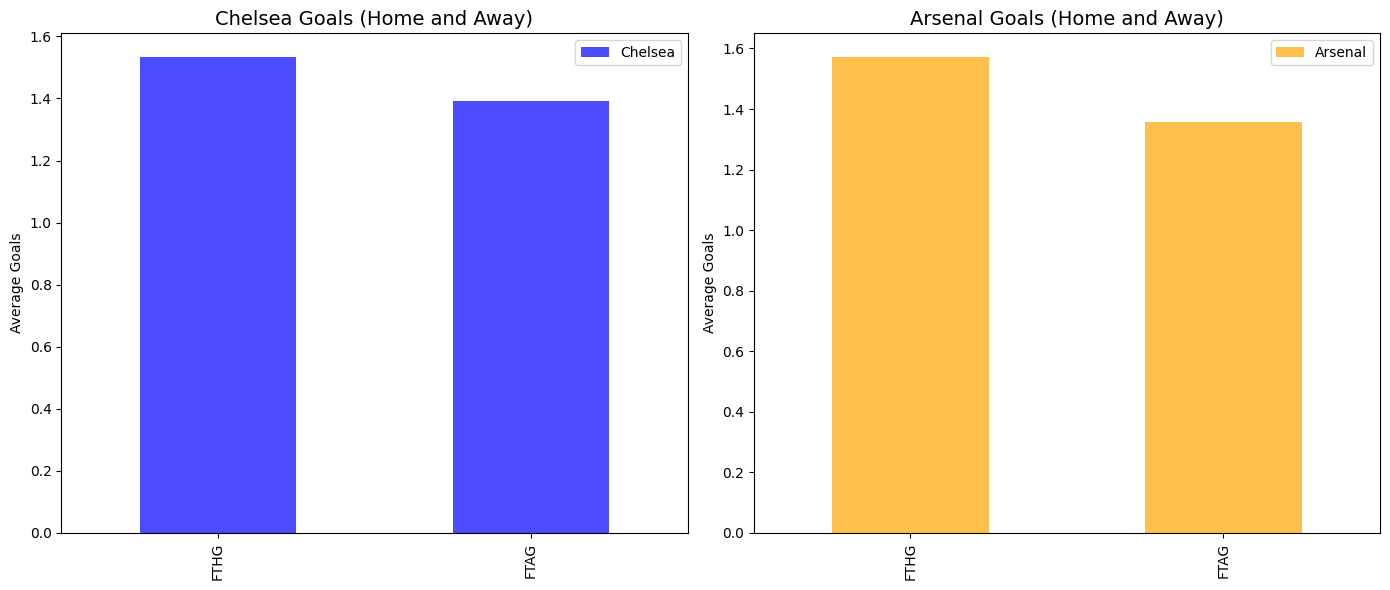

In [13]:
compare_teams(data, team_mapping, "Chelsea", "Arsenal")

In [45]:
def display_team_stats(data, team_mapping, team_name):
    """
    Displays match statistics for a given team.

    Parameters:
    - data (pd.DataFrame): The dataset including match details.
    - team_mapping (dict): Mapping of team names to numeric values.
    - team_name (str): The name of the team to analyze.
    """
    # Map team name to numeric value
    team_id = team_mapping.get(team_name)

    if team_id is None:
        print(f"Team '{team_name}' not found in the dataset.")
        return

    # Filter matches involving the specified team
    home_matches = data[data['HomeTeam'] == team_id]
    away_matches = data[data['AwayTeam'] == team_id]

    # Calculate statistics
    total_matches = len(home_matches) + len(away_matches)
    total_home_goals = home_matches['FTHG'].sum()
    total_away_goals = away_matches['FTAG'].sum()
    total_goals_conceded_home = home_matches['FTAG'].sum()
    total_goals_conceded_away = away_matches['FTHG'].sum()

    # Wins, Draws, Losses
    home_wins = len(home_matches[home_matches['FTR'] == 0])
    away_wins = len(away_matches[away_matches['FTR'] == 2])
    draws = len(home_matches[home_matches['FTR'] == 1]) + len(away_matches[away_matches['FTR'] == 1])
    losses = total_matches - (home_wins + away_wins + draws)

    # Display statistics
    print(f"Statistics for {team_name}:")
    print(f"Total Matches Played: {total_matches}")
    print(f"Total Goals Scored: {total_home_goals + total_away_goals}")
    print(f"Total Goals Conceded: {total_goals_conceded_home + total_goals_conceded_away}")
    print(f"Home Wins: {home_wins}")
    print(f"Away Wins: {away_wins}")
    print(f"Draws: {draws}")
    print(f"Losses: {losses}")

    # Plot goals scored and conceded
    goals = {
        'Home Goals Scored': total_home_goals,
        'Away Goals Scored': total_away_goals,
        'Home Goals Conceded': total_goals_conceded_home,
        'Away Goals Conceded': total_goals_conceded_away
    }
    plt.figure(figsize=(10, 6))
    plt.bar(goals.keys(), goals.values(), color=['blue', 'cyan', 'red', 'orange'])
    plt.title(f"Goals Breakdown for {team_name}", fontsize=16)
    plt.ylabel("Number of Goals")
    plt.show()


In [46]:
print(team_mapping)

{'Man United': 0, 'Ipswich': 1, 'Arsenal': 2, 'Everton': 3, 'Newcastle': 4, "Nott'm Forest": 5, 'West Ham': 6, 'Brentford': 7, 'Chelsea': 8, 'Leicester': 9, 'Brighton': 10, 'Crystal Palace': 11, 'Fulham': 12, 'Man City': 13, 'Southampton': 14, 'Tottenham': 15, 'Aston Villa': 16, 'Bournemouth': 17, 'Wolves': 18, 'Liverpool': 19, 'Burnley': 20, 'Sheffield United': 21, 'Luton': 22, 'Leeds': 23, 'Watford': 24, 'Norwich': 25, 'West Brom': 26}


Statistics for Arsenal:
Total Matches Played: 210
Total Goals Scored: 390
Total Goals Conceded: 225
Home Wins: 66
Away Wins: 53
Draws: 42
Losses: 49


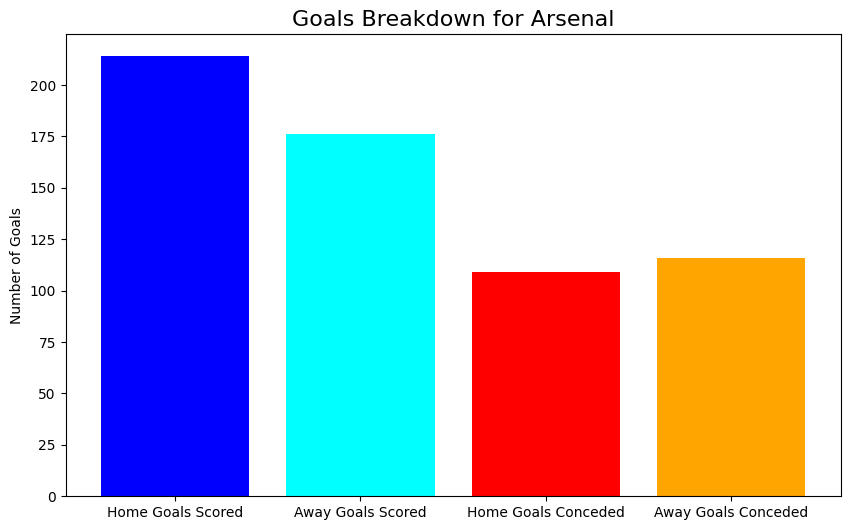

In [47]:
display_team_stats(data, team_mapping, "Arsenal")

In [48]:
# Train/test split and model training (unchanged)
X = data[features]
y = data['FTR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [49]:

# Evaluate Model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       313
           1       1.00      1.00      1.00       152
           2       1.00      1.00      1.00       228

    accuracy                           1.00       693
   macro avg       1.00      1.00      1.00       693
weighted avg       1.00      1.00      1.00       693



In [50]:

# Feature Importance
feature_importances = pd.DataFrame(
    {'Feature': features, 'Importance': model.feature_importances_}
).sort_values(by='Importance', ascending=False)
print(feature_importances)

            Feature  Importance
17   GoalDifference    0.508349
2              FTHG    0.170592
3              FTAG    0.149496
6               HST    0.031119
7               AST    0.024076
14             AvgH    0.023415
16             AvgA    0.017436
5                AS    0.010222
4                HS    0.010214
15             AvgD    0.009731
18  MarketConsensus    0.009334
0          HomeTeam    0.006902
1          AwayTeam    0.006400
9                AC    0.006271
8                HC    0.005804
10               HY    0.004587
11               AY    0.004166
12               HR    0.001001
13               AR    0.000885


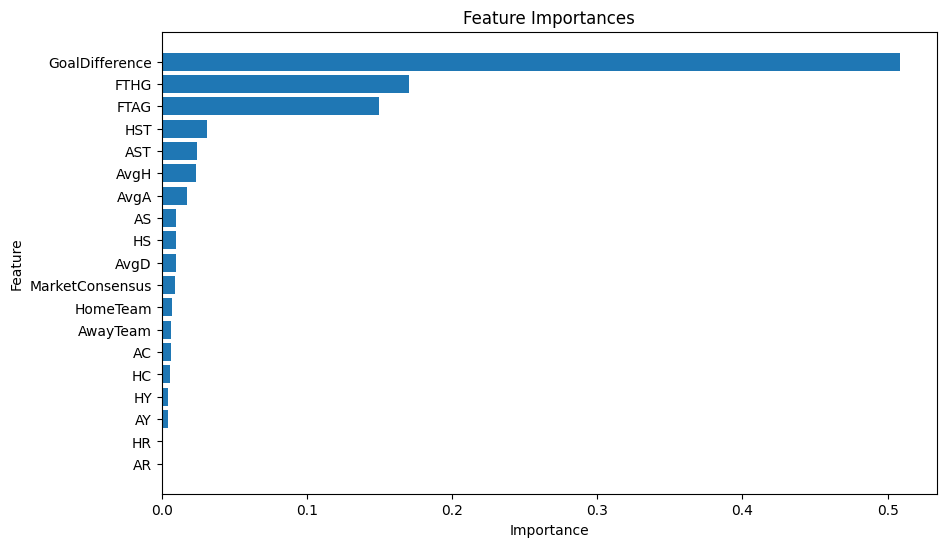

In [51]:
# Get feature importances from the model
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.gca().invert_yaxis()  # Invert y-axis to show most important feature at the top
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [14]:
list(data['HomeTeam'].values)

[np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8),
 np.int64(9),
 np.int64(10),
 np.int64(11),
 np.int64(12),
 np.int64(13),
 np.int64(14),
 np.int64(15),
 np.int64(16),
 np.int64(17),
 np.int64(18),
 np.int64(19),
 np.int64(2),
 np.int64(7),
 np.int64(3),
 np.int64(1),
 np.int64(9),
 np.int64(5),
 np.int64(6),
 np.int64(8),
 np.int64(4),
 np.int64(0),
 np.int64(14),
 np.int64(10),
 np.int64(11),
 np.int64(12),
 np.int64(19),
 np.int64(13),
 np.int64(16),
 np.int64(17),
 np.int64(15),
 np.int64(18),
 np.int64(6),
 np.int64(16),
 np.int64(12),
 np.int64(9),
 np.int64(19),
 np.int64(14),
 np.int64(15),
 np.int64(11),
 np.int64(10),
 np.int64(13),
 np.int64(4),
 np.int64(2),
 np.int64(7),
 np.int64(8),
 np.int64(3),
 np.int64(5),
 np.int64(18),
 np.int64(1),
 np.int64(0),
 np.int64(17),
 np.int64(11),
 np.int64(2),
 np.int64(7),
 np.int64(9),
 np.int64(13),
 np.int64(6),
 np.int64(3),
 np.int64(16),
 np.int64(8),
 

In [15]:
def calculateOverallPerformance(data):
    # Calculate total matches and wins for each team (Home = 1, Away=-1
    home_wins = data[data['FTR'] == 'H'].groupby('HomeTeam').size()  # Home wins
    away_wins = data[data['FTR'] == 'A'].groupby('AwayTeam').size()  # Away wins
    
    home_matches = data.groupby('HomeTeam').size()  # Total home matches
    away_matches = data.groupby('AwayTeam').size()  # Total away matches
    
    # Total matches and wins
    total_wins = home_wins.add(away_wins, fill_value=0)
    total_matches = home_matches.add(away_matches, fill_value=0)
    
    # Calculate win percentage
    win_percentage = (total_wins / total_matches) * 100
    
    # Sort win percentage in descending order
    win_percentage = win_percentage.sort_values(ascending=False)
    
    # Bar plot is better than a scatter plot for this:
    plt.figure(figsize=(12, 6))
    win_percentage.plot(kind='bar', color='skyblue', alpha=0.8, edgecolor='black')
    plt.title('Team Win Percentage')
    plt.xlabel('Team Name')
    plt.ylabel('Win Percentage (%)')
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

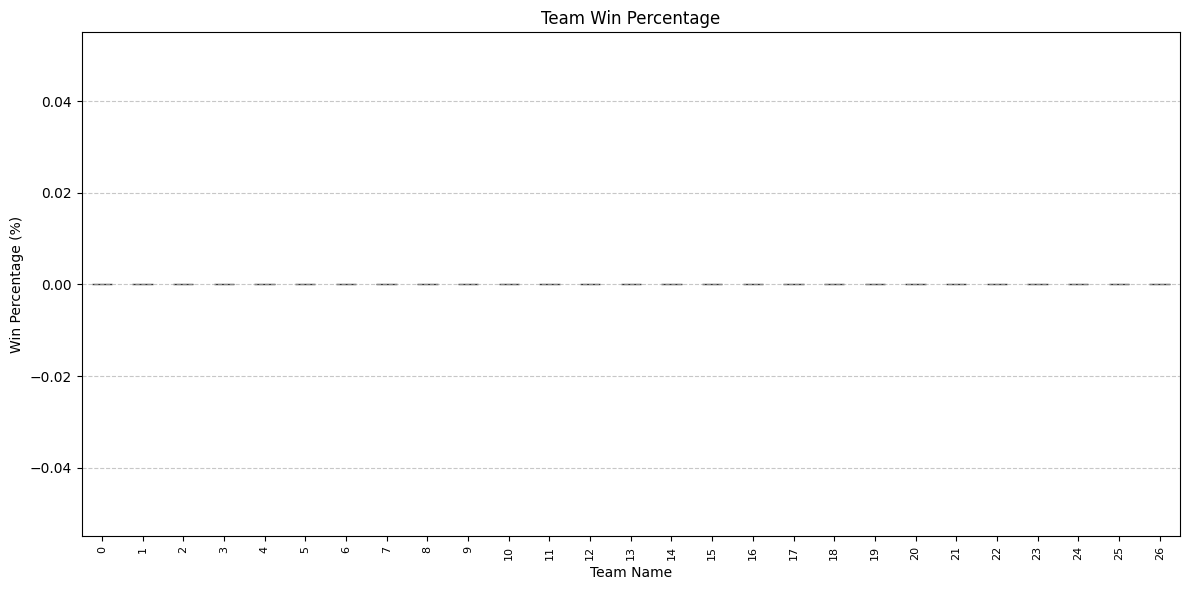

In [16]:
calculateOverallPerformance(data)